Câu hỏi: 
- Các yếu tố ảnh hưởng đến NHS waiting times, đặc biệt ở giai đoạn tăng sau Covid?
- Giả sử tăng workforce lên, thì waiting times có giảm ko?

Data:

NHS England (RTT waiting times, A&E 4-hour target): https://www.england.nhs.uk/statistics/statistical-work-areas/rtt-waiting-times/?

NHS Workforce (staff shortages)

UK Gov (NHS funding)

ONS Population (aging demand)

Phân tích: Interrupted Time Series (Covid shock), DiD (trusts funding khác nhau).

DS: Forecast waiting times, survival analysis cho “time-to-treatment”.

# <span style="color:#ffffff; font-size: 1%;"> 1. Introduction </span>

<div style=" border-bottom: 8px solid #9CBDFF; overflow: hidden; border-radius: 10px; height: 45px; width: 100%; display: flex;">
  <div style="height: 100%; width: 75%; background-color: #4b70c0; float: left; text-align: center; display: flex; justify-content: center; align-items: center; font-size: 25px; ">
    <b><span style="color: #ffffff; padding: 20px 20px;"> 1. 🏥 NHS Organisation and Data Sources </span></b>
  </div>
  <div style="height: 100%; width: 25%; background-image: url('https://peopleshistorynhs.org/wp-content/uploads/2016/01/nhs-logo-880x4951.jpeg'); background-size: cover; background-position: center; float: left; border-top-right-radius: 10px; border-bottom-right-radius: 4px;">
  </div>
</div>

##  <span style="color:#ffffff; font-size: 1%;"> 1.1 NHS Structure and Organisation </span>
<b><span style="color: #FFFFFF; background-color: #DBA742; padding: 20px; font-size: 18px; border-left: 8px solid #FFF8E8"> <strong> 1.1 🏛️ NHS Structure and Organisation  </strong></span></b>

The NHS in **England** is structured into several layers:  

- **NHS England (national)**  
  - Sets policy, targets, allocates funding.  

- **Regions** (7 in total: London, Midlands, North West, North East & Yorkshire, South East, South West, East of England)  
  - Strategic oversight and coordination across multiple ICS.  

- **ICS (Integrated Care System)**  
  - Improve outcomes in population health and healthcare
  - Tackle inequalities in outcomes, experience and access
  - Enhance productivity and value for money
  - Help the NHS support broader social and economic development

- **ICB (Integrated Care Board) = Commissioner**  
  - Plan health services for the local population.  
  - Does not provide care directly.  

- **NHS Trusts / Foundation Trusts (Providers)**  
  - Operate hospitals and community services.  
  - Responsible for delivering patient care.  

- **Hospitals / Services**  
  - Where treatment actually happens (e.g. Royal London Hospital).  

📊 **Hierarchy**:  
England → Region → ICS → ICB (Commissioner) → Trust (Provider) → Hospital  

---
Example: How a Patient Gets Care in NHS  

1. **Register with GP** – patient must be linked to a local GP practice.  
2. **Book appointment** – call/online form to see the GP.  
3. **GP consultation**  
   - Minor illness → GP prescribes medicine (go to pharmacy).  
   - Complex/serious → GP makes referral to hospital (specialist).  
4. **Waiting list (RTT)** – patient joins the referral-to-treatment list.  
5. **Treatment**  
   - **Admitted** → inpatient/day case (surgery).  
   - **Non-admitted** → outpatient/procedure.  
6. **Follow-up** – after treatment, patient is discharged and may return to GP.  


##  <span style="color:#ffffff; font-size: 1%;"> 1.2 NHS Data Sources </span>
<b><span style="color: #FFFFFF; background-color: #DBA742; padding: 20px; font-size: 18px; border-left: 8px solid #FFF8E8"> <strong> 1.2 📂 NHS Data Sources  </strong></span></b> 

To analyse waiting times, multiple datasets are needed:  

- **RTT (Referral to Treatment) Waiting Times – NHS England**  
  - Monthly, by Commissioner (ICB) and Provider (Trust).  
  - Four key datasets:  
    - *Incomplete* = patients still waiting (backlog).  
    - *Admitted* = patients treated with admission (inpatient/day case).  
    - *NonAdmitted* = patients treated without admission (outpatient/procedures).  
    - *New Periods* = new referrals added to the waiting list.  
  - Also available as a **Full CSV extract** (all types + both Commissioner & Provider).  

- **NHS Workforce Statistics – NHS Digital**  
  - Monthly staff numbers, Full-Time Equivalent (FTE), vacancies.  
  - Available at England, region, and trust level.  

- **UK Government Funding – DHSC / HM Treasury**  
  - Yearly budget and spending reports (PESA, NHS England annual accounts).  

- **ONS Population Estimates & Projections**  
  - Yearly data on population size and age structure.  
  - Crucial for analysing **aging demand**. 

##  <span style="color:#ffffff; font-size: 1%;"> 1.3 NHS Waiting Times: Median Calculation from Grouped Data </span>
<b><span style="color: #FFFFFF; background-color: #DBA742; padding: 20px; font-size: 18px; border-left: 8px solid #FFF8E8"> <strong> 1.3 🏛️ NHS Waiting Times: Median Calculation from Grouped Data  </strong></span></b>

The **median waiting time** is more than just a descriptive statistic — it is a **key feature** in many downstream models and decision frameworks.
In our NHS analysis, this metric will serve as:

- A **target variable** in regression models (e.g., predicting median wait time based on funding, staff count, population age structure)
- A **moderator** in causal graphs (e.g., how does increased funding moderate the effect of staff levels on wait times?)
- A **performance metric** to evaluate intervention impact (e.g., before/after median shift due to a new policy)

By carefully calculating median wait times from grouped data, we ensure our models are **both statistically valid and policy-relevant**.

The **NHS (National Health Service)** in England publishes **waiting time statistics** using *grouped data* (also called interval data) rather than individual patient-level records.

This part explains the method to **calculate the median waiting time** from such grouped data using **statistical interpolation methods**.

---

**❓ Problem Statement**

Consider the following grouped waiting time data:

| Waiting Time Band | Number of Patients |
|-------------------|--------------------|
| 0–1 weeks         | 3                  |
| 1–2 weeks         | 2                  |
| 2–3 weeks         | 4                  |
| 3–4 weeks         | 1                  |

Our challenge is to **estimate the median waiting time**, even though we **do not know the exact wait** for any individual patient. For example:

> Did the 4 patients in the 2–3 week band wait 2.1, 2.5, or 2.9 weeks?

---

**📎 Why NHS Uses This Method**

From official NHS documentation:

> “Median waiting times are calculated from aggregate data, rather than patient level data, and therefore are only estimates of the position on average waits.”

✅ Reasons:

- **Privacy protection** — avoids exposing individual-level medical data  
- **Data storage efficiency** — grouped formats reduce file size  
- **Statistical validity** — medians estimated from grouped data are often sufficient for public reporting  

---

**🧮 Mathematical Foundation**

**Step 1**: Find Total Patients (N) <br>

**Step 2**: Determine Median Position
- If N is even: median = average of positions N/2 and (N/2 + 1)
- If N is odd: median = position (N+1)/2

**Step 3**: Calculate Cumulative Frequencies <br>
- Track how many patients we've counted up to each band.

**Step 4**: Locate the Band Containing Median Position <br>
- Find which band contains the median position(s).

**Step 5**: Interpolate Within the Band <br>
- Key assumption: Patients are uniformly distributed within each band. <br>

Interpolation formula:
> estimated_time = band_start + (position_in_band - prev_cumulative - 0.5) / patients_in_band × band_width


# <span style="color:#ffffff; font-size: 1%;"> 2. Data preparation </span>

<div style=" border-bottom: 8px solid #9CBDFF; overflow: hidden; border-radius: 10px; height: 45px; width: 100%; display: flex;">
  <div style="height: 100%; width: 65%; background-color: #4b70c0; float: left; text-align: center; display: flex; justify-content: center; align-items: center; font-size: 25px; ">
    <b><span style="color: #ffffff; padding: 20px 20px;"> 2. 💊 Data Preparation </span></b>
  </div>
  <div style="height: 100%; width: 35%; background-image: url('https://peopleshistorynhs.org/wp-content/uploads/2016/01/nhs-logo-880x4951.jpeg'); background-size: cover; background-position: center; float: left; border-top-right-radius: 10px; border-bottom-right-radius: 4px;">
  </div>
</div>

In [9]:
# provider_trust, month, new_period_rrt, complete-admitted, complete-non-admitted, incomplete_eop, incomplete_dta, Incomplete median waiting time, Admitted median waiting time, Non-Admitted median waiting time, # staff, funding amount, # people gt 60 years old, Treatment Function

| Column name                      | Level              | Meaning                                                                                | Example                                      |
| -------------------------------- | ------------------ | -------------------------------------------------------------------------------------- | -------------------------------------------- |
| **Provider Parent Org Code**     | Trust (Parent)     | Code of the NHS Trust (parent organisation)                                            | `RJ1`                                        |
| **Provider Parent Name**         | Trust (Parent)     | Name of the NHS Trust                                                                  | Guy’s and St Thomas’ NHS Foundation Trust    |
| **Provider Org Code**            | Hospital / Site    | Code of the hospital/site under the Trust (can also be an Independent Sector provider) | `R0A`, `A4M8P`                               |
| **Provider Org Name**            | Hospital / Site    | Name of the hospital/site                                                              | St Thomas’ Hospital, Buckshaw Hospital       |
| **Commissioner Parent Org Code** | Region (Parent)    | Code of the commissioner’s parent (usually NHS England Region)                         | `QMM`                                        |
| **Commissioner Parent Name**     | Region (Parent)    | Name of the commissioner’s parent (Region)                                             | NHS London                                   |
| **Commissioner Org Code**        | ICB (Commissioner) | Code of the Integrated Care Board (commissioner)                                       | `02T`, `QMM`                                 |
| **Commissioner Org Name**        | ICB (Commissioner) | Name of the Integrated Care Board                                                      | NHS Greater Manchester Integrated Care Board |


In [10]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

In [11]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

https://www.england.nhs.uk/statistics/statistical-work-areas/rtt-waiting-times/

In [12]:
# import the main dataset
df = pd.read_csv('20250630-RTT-June-2025-full-extract.csv')
df.head()

,Period,Provider Parent Org Code,Provider Parent Name,Provider Org Code,Provider Org Name,Commissioner Parent Org Code,Commissioner Parent Name,Commissioner Org Code,Commissioner Org Name,RTT Part Type,RTT Part Description,Treatment Function Code,Treatment Function Name,Gt 00 To 01 Weeks SUM 1,Gt 01 To 02 Weeks SUM 1,Gt 02 To 03 Weeks SUM 1,Gt 03 To 04 Weeks SUM 1,Gt 04 To 05 Weeks SUM 1,Gt 05 To 06 Weeks SUM 1,Gt 06 To 07 Weeks SUM 1,Gt 07 To 08 Weeks SUM 1,Gt 08 To 09 Weeks SUM 1,Gt 09 To 10 Weeks SUM 1,Gt 10 To 11 Weeks SUM 1,Gt 11 To 12 Weeks SUM 1,Gt 12 To 13 Weeks SUM 1,Gt 13 To 14 Weeks SUM 1,Gt 14 To 15 Weeks SUM 1,Gt 15 To 16 Weeks SUM 1,Gt 16 To 17 Weeks SUM 1,Gt 17 To 18 Weeks SUM 1,Gt 18 To 19 Weeks SUM 1,Gt 19 To 20 Weeks SUM 1,Gt 20 To 21 Weeks SUM 1,Gt 21 To 22 Weeks SUM 1,Gt 22 To 23 Weeks SUM 1,Gt 23 To 24 Weeks SUM 1,Gt 24 To 25 Weeks SUM 1,Gt 25 To 26 Weeks SUM 1,Gt 26 To 27 Weeks SUM 1,Gt 27 To 28 Weeks SUM 1,Gt 28 To 29 Weeks SUM 1,Gt 29 To 30 Weeks SUM 1,Gt 30 To 31 Weeks SUM 1,Gt 31 To 32 Weeks SUM 1,Gt 32 To 33 Weeks SUM 1,Gt 33 To 34 Weeks SUM 1,Gt 34 To 35 Weeks SUM 1,Gt 35 To 36 Weeks SUM 1,Gt 36 To 37 Weeks SUM 1,Gt 37 To 38 Weeks SUM 1,Gt 38 To 39 Weeks SUM 1,Gt 39 To 40 Weeks SUM 1,Gt 40 To 41 Weeks SUM 1,Gt 41 To 42 Weeks SUM 1,Gt 42 To 43 Weeks SUM 1,Gt 43 To 44 Weeks SUM 1,Gt 44 To 45 Weeks SUM 1,Gt 45 To 46 Weeks SUM 1,Gt 46 To 47 Weeks SUM 1,Gt 47 To 48 Weeks SUM 1,Gt 48 To 49 Weeks SUM 1,Gt 49 To 50 Weeks SUM 1,Gt 50 To 51 Weeks SUM 1,Gt 51 To 52 Weeks SUM 1,Gt 52 To 53 Weeks SUM 1,Gt 53 To 54 Weeks SUM 1,Gt 54 To 55 Weeks SUM 1,Gt 55 To 56 Weeks SUM 1,Gt 56 To 57 Weeks SUM 1,Gt 57 To 58 Weeks SUM 1,Gt 58 To 59 Weeks SUM 1,Gt 59 To 60 Weeks SUM 1,Gt 60 To 61 Weeks SUM 1,Gt 61 To 62 Weeks SUM 1,Gt 62 To 63 Weeks SUM 1,Gt 63 To 64 Weeks SUM 1,Gt 64 To 65 Weeks SUM 1,Gt 65 To 66 Weeks SUM 1,Gt 66 To 67 Weeks SUM 1,Gt 67 To 68 Weeks SUM 1,Gt 68 To 69 Weeks SUM 1,Gt 69 To 70 Weeks SUM 1,Gt 70 To 71 Weeks SUM 1,Gt 71 To 72 Weeks SUM 1,Gt 72 To 73 Weeks SUM 1,Gt 73 To 74 Weeks SUM 1,Gt 74 To 75 Weeks SUM 1,Gt 75 To 76 Weeks SUM 1,Gt 76 To 77 Weeks SUM 1,Gt 77 To 78 Weeks SUM 1,Gt 78 To 79 Weeks SUM 1,Gt 79 To 80 Weeks SUM 1,Gt 80 To 81 Weeks SUM 1,Gt 81 To 82 Weeks SUM 1,Gt 82 To 83 Weeks SUM 1,Gt 83 To 84 Weeks SUM 1,Gt 84 To 85 Weeks SUM 1,Gt 85 To 86 Weeks SUM 1,Gt 86 To 87 Weeks SUM 1,Gt 87 To 88 Weeks SUM 1,Gt 88 To 89 Weeks SUM 1,Gt 89 To 90 Weeks SUM 1,Gt 90 To 91 Weeks SUM 1,Gt 91 To 92 Weeks SUM 1,Gt 92 To 93 Weeks SUM 1,Gt 93 To 94 Weeks SUM 1,Gt 94 To 95 Weeks SUM 1,Gt 95 To 96 Weeks SUM 1,Gt 96 To 97 Weeks SUM 1,Gt 97 To 98 Weeks SUM 1,Gt 98 To 99 Weeks SUM 1,Gt 99 To 100 Weeks SUM 1,Gt 100 To 101 Weeks SUM 1,Gt 101 To 102 Weeks SUM 1,Gt 102 To 103 Weeks SUM 1,Gt 103 To 104 Weeks SUM 1,Gt 104 Weeks SUM 1,Total,Patients with unknown clock start date,Total All
0,RTT-June-2025,QE1,NHS LANCASHIRE AND SOUTH CUMBRIA INTEGRATED CARE BOARD,A4M8P,BUCKSHAW HOSPITAL,NaN,NaN,13Q,NATIONAL COMMISSIONING HUB 1,Part_1B,Completed Pathways For Non-Admitted Patients,C_100,General Surgery Service,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2
1,RTT-June-2025,QE1,NHS LANCASHIRE AND SOUTH CUMBRIA INTEGRATED CARE BOARD,A4M8P,BUCKSHAW HOSPITAL,NaN,NaN,13Q,NATIONAL COMMISSIONING HUB 1,Part_1B,Completed Pathways For Non-Admitted Patients,C_999,Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [13]:
df.shape

(184732, 121)

##  <span style="color:#ffffff; font-size: 1%;"> 2.1 Waiting Time Data </span>
<b><span style="color: #FFFFFF; background-color: #DBA742; padding: 20px; font-size: 18px; border-left: 8px solid #FFF8E8"> <strong> 2.1 Waiting Time Data  </strong></span></b> 

### 2.1.1 New Periods Provider

In [51]:
new_period = df[(df['RTT Part Description'] == 'New RTT Periods - All Patients') & (df['Treatment Function Code'] != 'C_999')]\
    .groupby(['Period', 'Provider Org Code']).agg({'Total All': 'sum'}).reset_index()
new_period = new_period[['Period', 'Provider Org Code', 'Total All']]
new_period.columns = ['Period', 'Provider Org Code', 'New RTT patients']
new_period.head()

,Period,Provider Org Code,New RTT patients
0,RTT-June-2025,A0C5S,76
1,RTT-June-2025,A1D1B,103
2,RTT-June-2025,A1U4J,68
3,RTT-June-2025,A4M8P,747
4,RTT-June-2025,A4Q9X,343


### 2.1.2 Completed non-admitted pathways

In [52]:
df['RTT Part Description'].unique()

array(['Completed Pathways For Non-Admitted Patients',
       'Incomplete Pathways', 'Completed Pathways For Admitted Patients',
       'Incomplete Pathways with DTA', 'New RTT Periods - All Patients'],
      dtype=object)

In [53]:
# create a function to estimate the median waiting time from grouped data, this will be applied for other RTT part types as well. The details of the method is explained in the notebook above
def estimate_waiting_time(row, quantile):
    """
    Estimate the waiting time at a given quantile (e.g. median or 95th percentile)
    from grouped RTT waiting time data using linear interpolation.

    This function assumes that the input row contains columns corresponding to 
    grouped time bands (e.g. "0-1 Weeks SUM", "1-2 Weeks SUM", ...) where each column 
    indicates the number of patients who waited within that time interval.

    The method works by identifying the interval in which the target quantile 
    (e.g., 50% for median) falls, and then interpolating linearly within that 
    interval under the assumption that patients are uniformly distributed.
    
    Parameters
    ----------
    row : pandas.Series
        A single row of the DataFrame containing counts of patients by waiting time band.
        
    quantile : float
        The quantile to estimate (e.g. 0.5 for median, 0.95 for 95th percentile).
    
    Returns
    -------
    float
        Estimated waiting time at the specified quantile, interpolated from grouped data.
    """ 
    
    week_cols = [c for c in df.columns if 'Weeks SUM' in c]
    
    # get total patients 
    counts = row[week_cols].values 
    total = counts.sum()
    
    # get the quantile position 
    if quantile == 0.5 and total %2 == 0:
        median_pos = total / 2 
    elif quantile == 0.5 and total %2 != 0:
        median_pos = (total+1)/2 
    else:
        median_pos = quantile * total
        
    # cal cumulative sum
    cum = np.cumsum(counts)
    
    # find the band where the quantile position falls into 
    band_index = None 
    for i, c in enumerate(cum):
        if median_pos <= c:
            band_index= i 
            break 
    # get the band edges, width, lower, upper, prev_cum
    edges = np.arange(len(week_cols)+1)
    lower = edges[band_index]
    upper = edges[band_index + 1]
    band_width = upper - lower 
    prev_cum = cum[band_index - 1]
    
    # calculate interpolated waiting time
    estimated_time = lower + (median_pos - prev_cum - 0.5) / total * band_width
    
    return estimated_time

In [54]:
# create a function to standardize the data processing for different RTT part types
def standardize_df(df, RTT_description):
    """
    This function filters, aggregates, and calculates median waiting time 
    for a given RTT Part Description (e.g., "Incomplete", "Admitted", "Non-admitted") 
    across all providers and treatment functions. It returns a clean, standardized 
    DataFrame suitable for downstream analysis or merging with other datasets.

    Steps performed:
    1. Filter the input DataFrame by RTT Part Description.
    2. Aggregate patient counts by time bands and compute total count.
    3. Group the data by ['Period', 'RTT Part Type', 'Provider Org Code', 'Treatment Function Code'].
    4. Estimate the median waiting time using linear interpolation from grouped data.
    5. Create a composite 'ID' field for joining.
    6. Drop irrelevant Treatment Function codes (e.g., 'C_999').
    7. Return a clean DataFrame with key variables.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Raw NHS RTT waiting time dataset including columns like:
        'Period', 'RTT Part Type', 'RTT Part Description', 
        'Provider Org Code', 'Treatment Function Code', 
        weekly time band columns, and 'Total All'.

    RTT_description : str
        The value in 'RTT Part Description' to filter on 
        (e.g., 'Incomplete', 'Admitted', 'Non-admitted').

    Returns
    -------
    pandas.DataFrame
    """
    
    df_standardized = df[(df['RTT Part Description'] == RTT_description) & (df['Treatment Function Code'] != 'C_999')].copy()
    
    week_cols = [c for c in df.columns if 'Weeks SUM' in c]
    agg_dict = {col: 'sum' for col in week_cols}
    agg_dict['Total All'] = 'sum'

    # group thy data by provider trust and treatment function
    df_standardized = df_standardized.groupby(['Period', 'RTT Part Type', 'Provider Org Code']).agg(agg_dict).reset_index()
    
    # estimate the median waiting time for each trust and treatment function
    df_standardized['Median Waiting Time'] = df_standardized.apply(lambda row: estimate_waiting_time(row,0.5), axis = 1)

    # now we have the estimated median waiting time 
    df_standardized = df_standardized[['Period', 'Provider Org Code', 'Total All', 'Median Waiting Time']]
    
    return df_standardized

In [56]:
completed_non_admitted = standardize_df(df, 'Completed Pathways For Non-Admitted Patients')
completed_non_admitted.columns = ['Period', 'Provider Org Code', 'Total Completed Non-Admitted', 'Median Waiting Time Non-Admitted']
completed_non_admitted.head()

,Period,Provider Org Code,Total Completed Non-Admitted,Median Waiting Time Non-Admitted
0,RTT-June-2025,A0C5S,33,2.015152
1,RTT-June-2025,A1D1B,41,2.109756
2,RTT-June-2025,A1U4J,18,3.138889
3,RTT-June-2025,A4M8P,249,10.114458
4,RTT-June-2025,A4Q9X,229,2.085153


### 2.1.2 Completed Admitted Pathways

In [57]:
completed_admitted = standardize_df(df, 'Completed Pathways For Admitted Patients')
completed_admitted.columns = ['Period', 'Provider Org Code', 'Total Completed Admitted', 'Median Waiting Time Admitted']
completed_admitted.head()

,Period,Provider Org Code,Total Completed Admitted,Median Waiting Time Admitted
0,RTT-June-2025,A0C5S,63,4.103175
1,RTT-June-2025,A1D1B,57,4.043860
2,RTT-June-2025,A1U4J,57,5.061404
3,RTT-June-2025,A4M8P,126,18.011905
4,RTT-June-2025,A4Q9X,147,1.227891


###  2.1.3 Incomplete Pathways with DTA

In [58]:
incomplete_dta = standardize_df(df, 'Incomplete Pathways with DTA')
incomplete_dta.columns = [ 'Period', 'Provider Org Code','Total Incomplete DTA', 'Median Waiting Time Incomplete DTA']
incomplete_dta.head()

,Period,Provider Org Code,Total Incomplete DTA,Median Waiting Time Incomplete DTA
0,RTT-June-2025,A0C5S,58,4.025862
1,RTT-June-2025,A1D1B,47,2.074468
2,RTT-June-2025,A1U4J,59,3.059322
3,RTT-June-2025,A4M8P,342,5.027778
4,RTT-June-2025,A4Q9X,70,3.050000


### 2.1.4 Incomplete Pathways

In [59]:
incomplete = standardize_df(df, 'Incomplete Pathways')
incomplete.columns = ['Period', 'Provider Org Code','Total Incomplete', 'Median Waiting Time Incomplete']
incomplete.head()

,Period,Provider Org Code,Total Incomplete,Median Waiting Time Incomplete
0,RTT-June-2025,A0C5S,89,3.028090
1,RTT-June-2025,A1D1B,103,2.092233
2,RTT-June-2025,A1U4J,85,3.017647
3,RTT-June-2025,A4M8P,3225,11.018450
4,RTT-June-2025,A4Q9X,233,2.066524


### 2.1.5 Waiting Time Combination

In [60]:
rtt_df = new_period.merge(completed_admitted, on = ['Period', 'Provider Org Code'], how ='outer')
rtt_df = rtt_df.merge(completed_non_admitted, on = ['Period', 'Provider Org Code'], how ='outer')
rtt_df = rtt_df.merge(incomplete_dta, on = ['Period', 'Provider Org Code'], how ='outer')
rtt_df = rtt_df.merge(incomplete, on = ['Period', 'Provider Org Code'], how ='outer')

rtt_df.head()

,Period,Provider Org Code,New RTT patients,Total Completed Admitted,Median Waiting Time Admitted,Total Completed Non-Admitted,Median Waiting Time Non-Admitted,Total Incomplete DTA,Median Waiting Time Incomplete DTA,Total Incomplete,Median Waiting Time Incomplete
0,RTT-June-2025,A0C5S,76.0,63.0,4.103175,33.0,2.015152,58.0,4.025862,89.0,3.028090
1,RTT-June-2025,A1D1B,103.0,57.0,4.043860,41.0,2.109756,47.0,2.074468,103.0,2.092233
2,RTT-June-2025,A1U4J,68.0,57.0,5.061404,18.0,3.138889,59.0,3.059322,85.0,3.017647
3,RTT-June-2025,A4M8P,747.0,126.0,18.011905,249.0,10.114458,342.0,5.027778,3225.0,11.018450
4,RTT-June-2025,A4Q9X,343.0,147.0,1.227891,229.0,2.085153,70.0,3.050000,233.0,2.066524


In [61]:
rtt_df.isnull().sum()

Period                                 0
Provider Org Code                      0
New RTT patients                       5
Total Completed Admitted              42
Median Waiting Time Admitted          42
Total Completed Non-Admitted           6
Median Waiting Time Non-Admitted       6
Total Incomplete DTA                  47
Median Waiting Time Incomplete DTA    47
Total Incomplete                       2
Median Waiting Time Incomplete         2
dtype: int64

##  <span style="color:#ffffff; font-size: 1%;"> 2.2 NHS Workforce </span>
<b><span style="color: #FFFFFF; background-color: #DBA742; padding: 20px; font-size: 18px; border-left: 8px solid #FFF8E8"> <strong> 2.2 NHS Workforce  </strong></span></b> 

Dataset is hierarchical, wide-format, and inconsistent. It mixes regions, ICS, trusts, old org types (PCT, CCG), has monthly columns across the sheet, and many missing/dash values. We will melt the monthly columns into a long tidy format with date and headcount for analysis.

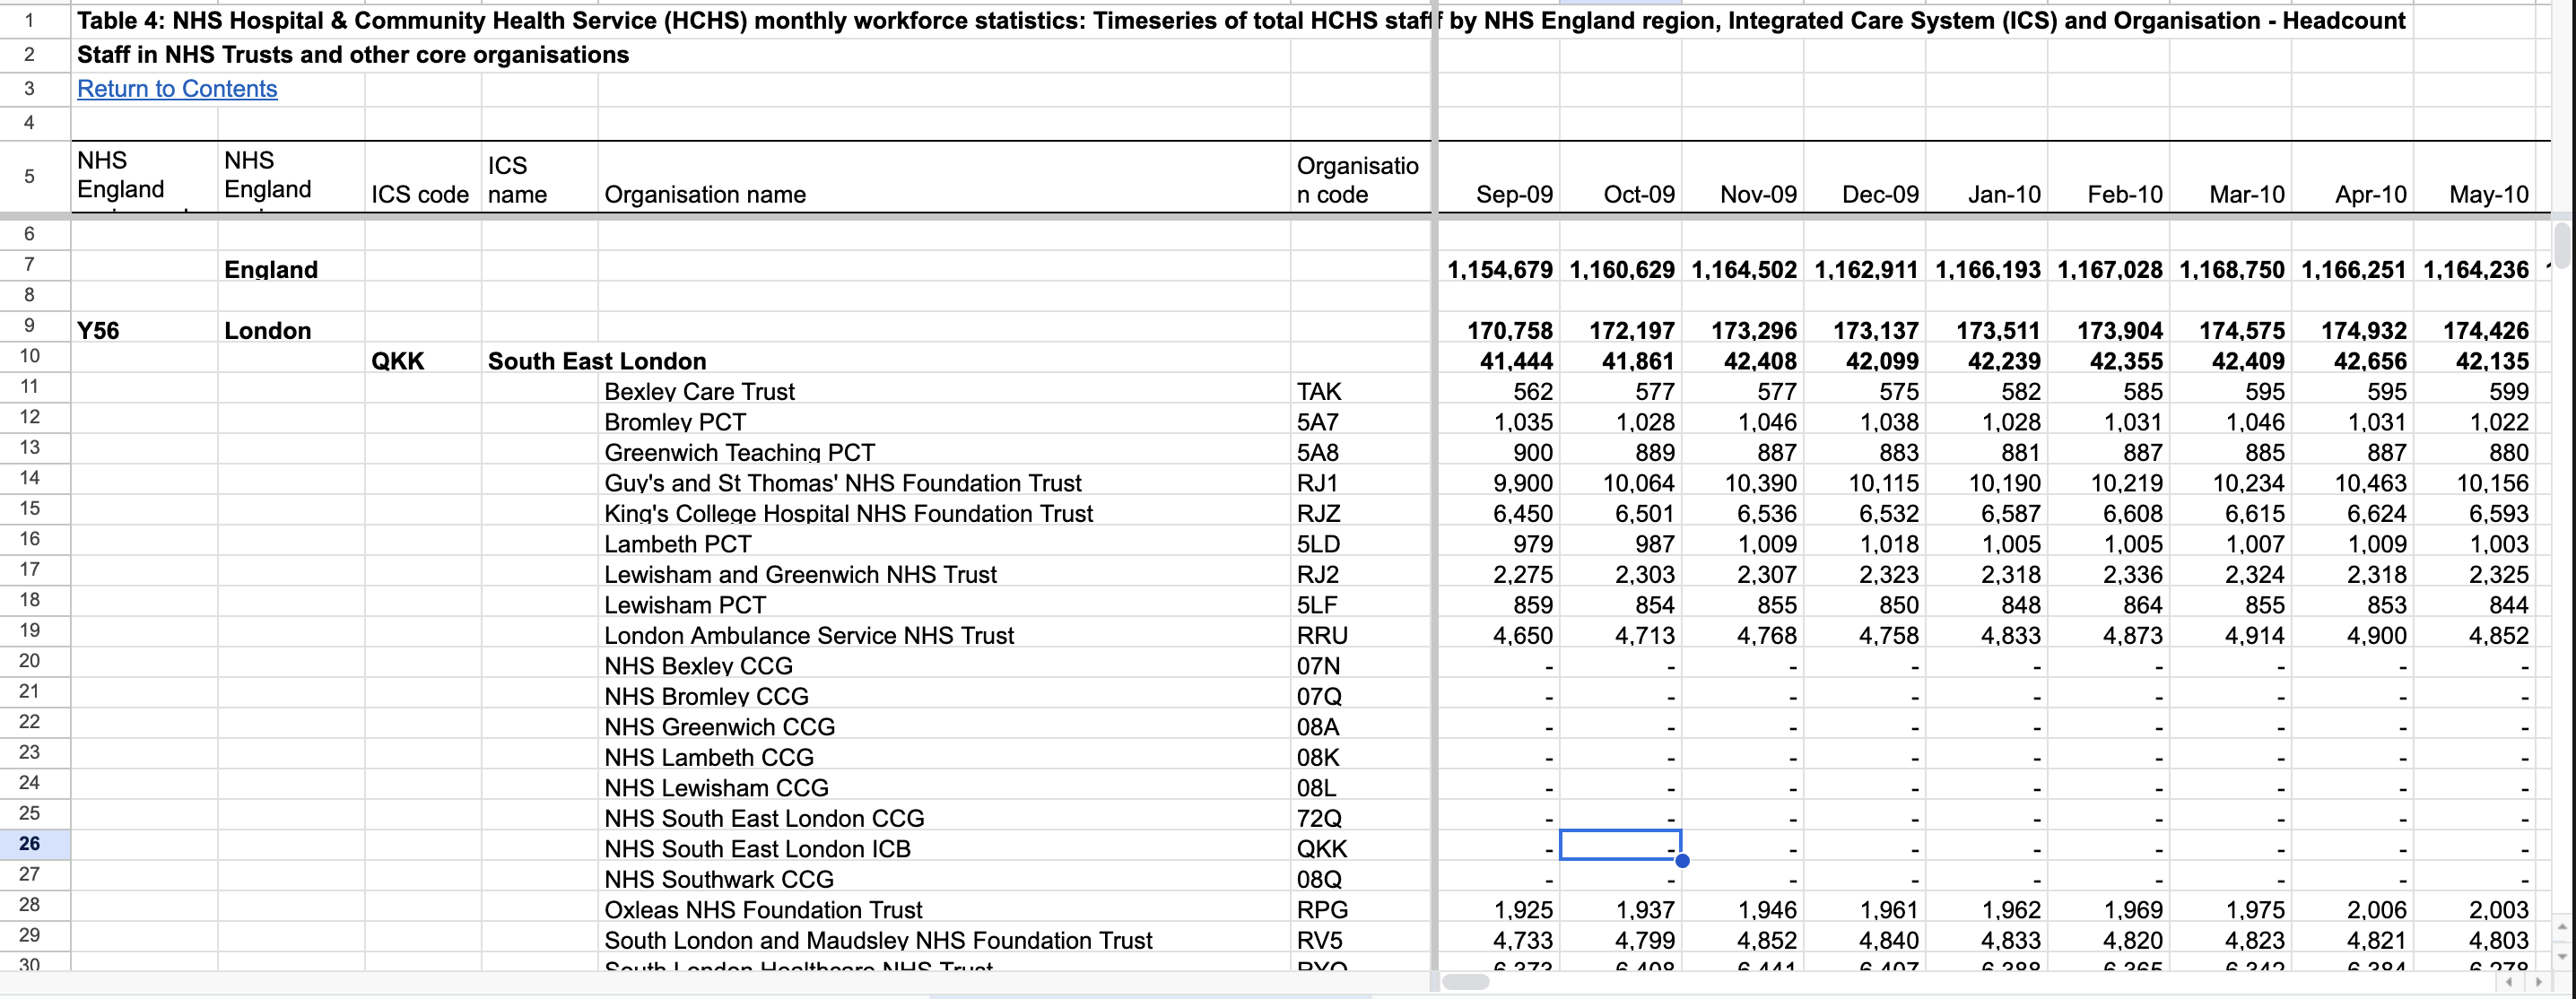

In [24]:
# import NHS workforce file, skip the first 4 rows, select specific sheet 
workforce = pd.read_excel('NHS Workforce Statistics, April 2025 England and Organisation.xlsx', sheet_name = '4. All Staff, NHSE & Org - HC', skiprows=4)
# delete the first 3 rows
workforce = workforce.drop(index = [0,1,2])
workforce.head()

,NHS England region code,NHS England region name,ICS code,ICS name,Organisation name,Organisation code,2009-09-30 00:00:00,2009-10-31 00:00:00,2009-11-30 00:00:00,2009-12-31 00:00:00,2010-01-31 00:00:00,2010-02-28 00:00:00,2010-03-31 00:00:00,2010-04-30 00:00:00,2010-05-31 00:00:00,2010-06-30 00:00:00,2010-07-31 00:00:00,2010-08-31 00:00:00,2010-09-30 00:00:00,2010-10-31 00:00:00,2010-11-30 00:00:00,2010-12-31 00:00:00,2011-01-31 00:00:00,2011-02-28 00:00:00,2011-03-31 00:00:00,2011-04-30 00:00:00,2011-05-31 00:00:00,2011-06-30 00:00:00,2011-07-31 00:00:00,2011-08-31 00:00:00,2011-09-30 00:00:00,2011-10-31 00:00:00,2011-11-30 00:00:00,2011-12-31 00:00:00,2012-01-31 00:00:00,2012-02-29 00:00:00,2012-03-31 00:00:00,2012-04-30 00:00:00,2012-05-31 00:00:00,2012-06-30 00:00:00,2012-07-31 00:00:00,2012-08-31 00:00:00,2012-09-30 00:00:00,2012-10-31 00:00:00,2012-11-30 00:00:00,2012-12-31 00:00:00,2013-01-31 00:00:00,2013-02-28 00:00:00,2013-03-31 00:00:00,2013-04-30 00:00:00,2013-05-31 00:00:00,2013-06-30 00:00:00,2013-07-31 00:00:00,2013-08-31 00:00:00,2013-09-30 00:00:00,2013-10-31 00:00:00,2013-11-30 00:00:00,2013-12-31 00:00:00,2014-01-31 00:00:00,2014-02-28 00:00:00,2014-03-31 00:00:00,2014-04-30 00:00:00,2014-05-31 00:00:00,2014-06-30 00:00:00,2014-07-31 00:00:00,2014-08-31 00:00:00,2014-09-30 00:00:00,2014-10-31 00:00:00,2014-11-30 00:00:00,2014-12-31 00:00:00,2015-01-31 00:00:00,2015-02-28 00:00:00,2015-03-31 00:00:00,2015-04-30 00:00:00,2015-05-31 00:00:00,2015-06-30 00:00:00,2015-07-31 00:00:00,2015-08-31 00:00:00,2015-09-30 00:00:00,2015-10-31 00:00:00,2015-11-30 00:00:00,2015-12-31 00:00:00,2016-01-31 00:00:00,2016-02-29 00:00:00,2016-03-31 00:00:00,2016-04-30 00:00:00,2016-05-31 00:00:00,2016-06-30 00:00:00,2016-07-31 00:00:00,2016-08-31 00:00:00,2016-09-30 00:00:00,2016-10-31 00:00:00,2016-11-30 00:00:00,2016-12-31 00:00:00,2017-01-31 00:00:00,2017-02-28 00:00:00,2017-03-31 00:00:00,2017-04-30 00:00:00,2017-05-31 00:00:00,2017-06-30 00:00:00,2017-07-31 00:00:00,2017-08-31 00:00:00,2017-09-30 00:00:00,2017-10-31 00:00:00,2017-11-30 00:00:00,2017-12-31 00:00:00,2018-01-31 00:00:00,2018-02-28 00:00:00,2018-03-31 00:00:00,2018-04-30 00:00:00,2018-05-31 00:00:00,2018-06-30 00:00:00,2018-07-31 00:00:00,2018-08-31 00:00:00,2018-09-30 00:00:00,2018-10-31 00:00:00,2018-11-30 00:00:00,2018-12-31 00:00:00,2019-01-31 00:00:00,2019-02-28 00:00:00,2019-03-31 00:00:00,2019-04-30 00:00:00,2019-05-31 00:00:00,2019-06-30 00:00:00,2019-07-31 00:00:00,2019-08-31 00:00:00,2019-09-30 00:00:00,2019-10-31 00:00:00,2019-11-30 00:00:00,2019-12-31 00:00:00,2020-01-31 00:00:00,2020-02-29 00:00:00,2020-03-31 00:00:00,2020-04-30 00:00:00,2020-05-31 00:00:00,2020-06-30 00:00:00,2020-07-31 00:00:00,2020-08-31 00:00:00,2020-09-30 00:00:00,2020-10-31 00:00:00,2020-11-30 00:00:00,2020-12-31 00:00:00,2021-01-31 00:00:00,2021-02-28 00:00:00,2021-03-31 00:00:00,2021-04-30 00:00:00,2021-05-31 00:00:00,2021-06-30 00:00:00,2021-07-31 00:00:00,2021-08-31 00:00:00,2021-09-30 00:00:00,2021-10-31 00:00:00,2021-11-30 00:00:00,2021-12-31 00:00:00,2022-01-31 00:00:00,2022-02-28 00:00:00,2022-03-31 00:00:00,2022-04-30 00:00:00,2022-05-31 00:00:00,2022-06-30 00:00:00,2022-07-31 00:00:00,2022-08-31 00:00:00,2022-09-30 00:00:00,2022-10-31 00:00:00,2022-11-30 00:00:00,2022-12-31 00:00:00,2023-01-31 00:00:00,2023-02-28 00:00:00,2023-03-31 00:00:00,2023-04-30 00:00:00,2023-05-31 00:00:00,2023-06-30 00:00:00,2023-07-31 00:00:00,2023-08-31 00:00:00,2023-09-30 00:00:00,2023-10-31 00:00:00,2023-11-30 00:00:00,2023-12-31 00:00:00,2024-01-31 00:00:00,2024-02-29 00:00:00,2024-03-31 00:00:00,2024-04-30 00:00:00,2024-05-31 00:00:00,2024-06-30 00:00:00,2024-07-31 00:00:00,2024-08-31 00:00:00,2024-09-30 00:00:00,2024-10-31 00:00:00,2024-11-30 00:00:00,2024-12-31 00:00:00,2025-01-31 00:00:00,2025-02-28 00:00:00,2025-03-31 00:00:00,2025-04-30 00:00:00
3,Y56,London,NaN,NaN,NaN,NaN,170758.0,172197.0,173296.0,173137.0,173511.0,173904.0,174575.0,174932.0,174426.0,174782.0,174567.0,175075.0,

In [25]:
# forward fill the missing values that suppose to be the same as above row
workforce[["NHS England region code", "NHS England region name", 'ICS code', 'ICS name']] = (
    workforce[["NHS England region code", "NHS England region name", 'ICS code', 'ICS name']].ffill()
)

workforce.dropna(inplace=True)
workforce.head()

,NHS England region code,NHS England region name,ICS code,ICS name,Organisation name,Organisation code,2009-09-30 00:00:00,2009-10-31 00:00:00,2009-11-30 00:00:00,2009-12-31 00:00:00,2010-01-31 00:00:00,2010-02-28 00:00:00,2010-03-31 00:00:00,2010-04-30 00:00:00,2010-05-31 00:00:00,2010-06-30 00:00:00,2010-07-31 00:00:00,2010-08-31 00:00:00,2010-09-30 00:00:00,2010-10-31 00:00:00,2010-11-30 00:00:00,2010-12-31 00:00:00,2011-01-31 00:00:00,2011-02-28 00:00:00,2011-03-31 00:00:00,2011-04-30 00:00:00,2011-05-31 00:00:00,2011-06-30 00:00:00,2011-07-31 00:00:00,2011-08-31 00:00:00,2011-09-30 00:00:00,2011-10-31 00:00:00,2011-11-30 00:00:00,2011-12-31 00:00:00,2012-01-31 00:00:00,2012-02-29 00:00:00,2012-03-31 00:00:00,2012-04-30 00:00:00,2012-05-31 00:00:00,2012-06-30 00:00:00,2012-07-31 00:00:00,2012-08-31 00:00:00,2012-09-30 00:00:00,2012-10-31 00:00:00,2012-11-30 00:00:00,2012-12-31 00:00:00,2013-01-31 00:00:00,2013-02-28 00:00:00,2013-03-31 00:00:00,2013-04-30 00:00:00,2013-05-31 00:00:00,2013-06-30 00:00:00,2013-07-31 00:00:00,2013-08-31 00:00:00,2013-09-30 00:00:00,2013-10-31 00:00:00,2013-11-30 00:00:00,2013-12-31 00:00:00,2014-01-31 00:00:00,2014-02-28 00:00:00,2014-03-31 00:00:00,2014-04-30 00:00:00,2014-05-31 00:00:00,2014-06-30 00:00:00,2014-07-31 00:00:00,2014-08-31 00:00:00,2014-09-30 00:00:00,2014-10-31 00:00:00,2014-11-30 00:00:00,2014-12-31 00:00:00,2015-01-31 00:00:00,2015-02-28 00:00:00,2015-03-31 00:00:00,2015-04-30 00:00:00,2015-05-31 00:00:00,2015-06-30 00:00:00,2015-07-31 00:00:00,2015-08-31 00:00:00,2015-09-30 00:00:00,2015-10-31 00:00:00,2015-11-30 00:00:00,2015-12-31 00:00:00,2016-01-31 00:00:00,2016-02-29 00:00:00,2016-03-31 00:00:00,2016-04-30 00:00:00,2016-05-31 00:00:00,2016-06-30 00:00:00,2016-07-31 00:00:00,2016-08-31 00:00:00,2016-09-30 00:00:00,2016-10-31 00:00:00,2016-11-30 00:00:00,2016-12-31 00:00:00,2017-01-31 00:00:00,2017-02-28 00:00:00,2017-03-31 00:00:00,2017-04-30 00:00:00,2017-05-31 00:00:00,2017-06-30 00:00:00,2017-07-31 00:00:00,2017-08-31 00:00:00,2017-09-30 00:00:00,2017-10-31 00:00:00,2017-11-30 00:00:00,2017-12-31 00:00:00,2018-01-31 00:00:00,2018-02-28 00:00:00,2018-03-31 00:00:00,2018-04-30 00:00:00,2018-05-31 00:00:00,2018-06-30 00:00:00,2018-07-31 00:00:00,2018-08-31 00:00:00,2018-09-30 00:00:00,2018-10-31 00:00:00,2018-11-30 00:00:00,2018-12-31 00:00:00,2019-01-31 00:00:00,2019-02-28 00:00:00,2019-03-31 00:00:00,2019-04-30 00:00:00,2019-05-31 00:00:00,2019-06-30 00:00:00,2019-07-31 00:00:00,2019-08-31 00:00:00,2019-09-30 00:00:00,2019-10-31 00:00:00,2019-11-30 00:00:00,2019-12-31 00:00:00,2020-01-31 00:00:00,2020-02-29 00:00:00,2020-03-31 00:00:00,2020-04-30 00:00:00,2020-05-31 00:00:00,2020-06-30 00:00:00,2020-07-31 00:00:00,2020-08-31 00:00:00,2020-09-30 00:00:00,2020-10-31 00:00:00,2020-11-30 00:00:00,2020-12-31 00:00:00,2021-01-31 00:00:00,2021-02-28 00:00:00,2021-03-31 00:00:00,2021-04-30 00:00:00,2021-05-31 00:00:00,2021-06-30 00:00:00,2021-07-31 00:00:00,2021-08-31 00:00:00,2021-09-30 00:00:00,2021-10-31 00:00:00,2021-11-30 00:00:00,2021-12-31 00:00:00,2022-01-31 00:00:00,2022-02-28 00:00:00,2022-03-31 00:00:00,2022-04-30 00:00:00,2022-05-31 00:00:00,2022-06-30 00:00:00,2022-07-31 00:00:00,2022-08-31 00:00:00,2022-09-30 00:00:00,2022-10-31 00:00:00,2022-11-30 00:00:00,2022-12-31 00:00:00,2023-01-31 00:00:00,2023-02-28 00:00:00,2023-03-31 00:00:00,2023-04-30 00:00:00,2023-05-31 00:00:00,2023-06-30 00:00:00,2023-07-31 00:00:00,2023-08-31 00:00:00,2023-09-30 00:00:00,2023-10-31 00:00:00,2023-11-30 00:00:00,2023-12-31 00:00:00,2024-01-31 00:00:00,2024-02-29 00:00:00,2024-03-31 00:00:00,2024-04-30 00:00:00,2024-05-31 00:00:00,2024-06-30 00:00:00,2024-07-31 00:00:00,2024-08-31 00:00:00,2024-09-30 00:00:00,2024-10-31 00:00:00,2024-11-30 00:00:00,2024-12-31 00:00:00,2025-01-31 00:00:00,2025-02-28 00:00:00,2025-03-31 00:00:00,2025-04-30 00:00:00
5,Y56,London,QKK,South East London,Bexley Care Trust,TAK,562.0,577.0,577.0,575.0,582.0,585.0,595.0,595.0,599.0,605.0,592.0,153.0,157.0,15

In [26]:
# prepare for melting
id_vars = [
    "NHS England region code", "NHS England region name", 
    "ICS code", "ICS name",
    "Organisation code", "Organisation name"
]

value_vars = [c for c in workforce.columns if "-" in str(c)]

wf = workforce.melt(
    id_vars=id_vars,
    value_vars=value_vars,
    var_name="month",
    value_name="staff_HC"
)

wf["month"] = pd.to_datetime(wf["month"], format="%b-%y")

wf.head()

,NHS England region code,NHS England region name,ICS code,ICS name,Organisation code,Organisation name,month,staff_HC
0,Y56,London,QKK,South East London,TAK,Bexley Care Trust,2009-09-30,562.0
1,Y56,London,QKK,South East London,5A7,Bromley PCT,2009-09-30,1035.0
2,Y56,London,QKK,South East London,5A8,Greenwich Teaching PCT,2009-09-30,900.0
3,Y56,London,QKK,South East London,RJ1,Guy's and St Thomas' NHS Foundation Trust,2009-09-30,9900.0
4,Y56,London,QKK,South East London,RJZ,King's College Hospital NHS Foundation Trust,2009-09-30,6450.0


In [27]:
import pandas as pd

# Lấy unique codes từ 2 dataset
codes_rtt = set(rtt_df['Provider Org Code'].dropna().unique())
codes_workforce = set(wf['Organisation code'].dropna().unique())

# Giao nhau (chỉ giữ các Trust/Provider có mặt ở cả 2)
common_codes = codes_rtt & codes_workforce

# Filter RTT
rtt_filtered = rtt_df[rtt_df['Provider Org Code'].isin(common_codes)].copy()

# Filter Workforce
wf_filtered = wf[wf['Organisation code'].isin(common_codes)].copy()

print(f"Số mã chung: {len(common_codes)}")

Số mã chung: 151


In [28]:
wf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132164 entries, 0 to 132163
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   NHS England region code  132164 non-null  object        
 1   NHS England region name  132164 non-null  object        
 2   ICS code                 132164 non-null  object        
 3   ICS name                 132164 non-null  object        
 4   Organisation code        132164 non-null  object        
 5   Organisation name        132164 non-null  object        
 6   month                    132164 non-null  datetime64[ns]
 7   staff_HC                 132164 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 8.1+ MB


##  <span style="color:#ffffff; font-size: 1%;"> 2.3 Covid Cases </span>
<b><span style="color: #FFFFFF; background-color: #DBA742; padding: 20px; font-size: 18px; border-left: 8px solid #FFF8E8"> <strong> 2.3 Covid Cases  </strong></span></b> 

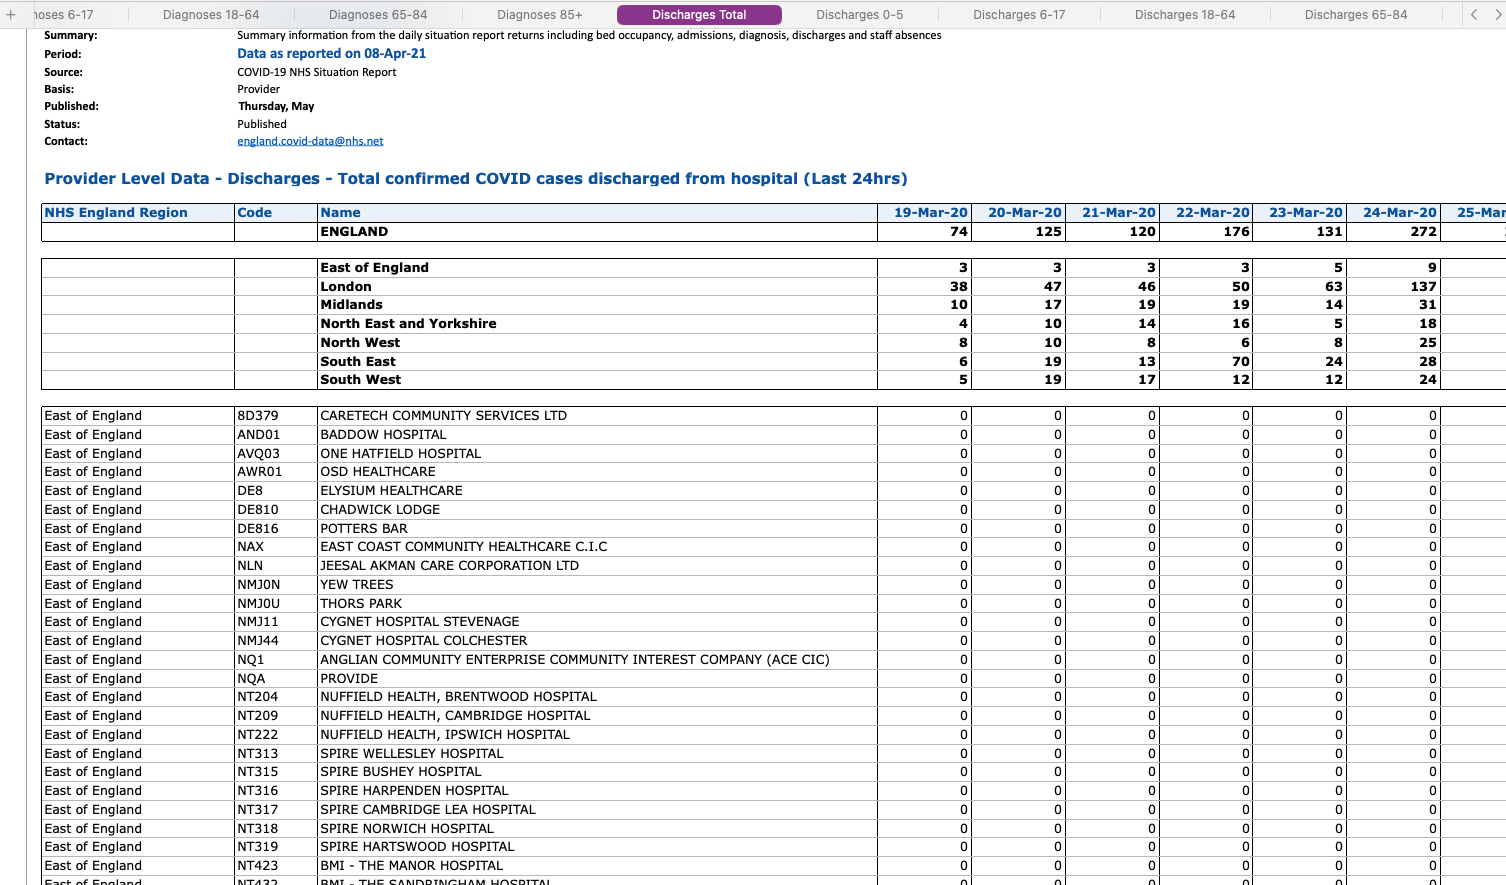

### 2.3.1 Admissions

In [92]:
def read_excel_covid(file_path, sheet_name):
    df = pd.read_excel(file_path,
                      sheet_name = sheet_name, skiprows = 12)

    df.drop(columns = ['Unnamed: 0'], inplace = True)
    df.drop(index = [0,1,2,3,4,5,6,7,8,9], inplace= True)
    return df

In [96]:
covid_admissions = read_excel_covid('raw-data/Covid-Publication-06-04-2021-up-to-200731-DQnotes.xlsx','Admissions Total' )
covid_admissions.head()

,NHS England Region,Code,Name,2020-03-19 00:00:00,2020-03-20 00:00:00,2020-03-21 00:00:00,2020-03-22 00:00:00,2020-03-23 00:00:00,2020-03-24 00:00:00,2020-03-25 00:00:00,2020-03-26 00:00:00,2020-03-27 00:00:00,2020-03-28 00:00:00,2020-03-29 00:00:00,2020-03-30 00:00:00,2020-03-31 00:00:00,2020-04-01 00:00:00,2020-04-02 00:00:00,2020-04-03 00:00:00,2020-04-04 00:00:00,2020-04-05 00:00:00,2020-04-06 00:00:00,2020-04-07 00:00:00,2020-04-08 00:00:00,2020-04-09 00:00:00,2020-04-10 00:00:00,2020-04-11 00:00:00,2020-04-12 00:00:00,2020-04-13 00:00:00,2020-04-14 00:00:00,2020-04-15 00:00:00,2020-04-16 00:00:00,2020-04-17 00:00:00,2020-04-18 00:00:00,2020-04-19 00:00:00,2020-04-20 00:00:00,2020-04-21 00:00:00,2020-04-22 00:00:00,2020-04-23 00:00:00,2020-04-24 00:00:00,2020-04-25 00:00:00,2020-04-26 00:00:00,2020-04-27 00:00:00,2020-04-28 00:00:00,2020-04-29 00:00:00,2020-04-30 00:00:00,2020-05-01 00:00:00,2020-05-02 00:00:00,2020-05-03 00:00:00,2020-05-04 00:00:00,2020-05-05 00:00:00,2020-05-06 00:00:00,2020-05-07 00:00:00,2020-05-08 00:00:00,2020-05-09 00:00:00,2020-05-10 00:00:00,2020-05-11 00:00:00,2020-05-12 00:00:00,2020-05-13 00:00:00,2020-05-14 00:00:00,2020-05-15 00:00:00,2020-05-16 00:00:00,2020-05-17 00:00:00,2020-05-18 00:00:00,2020-05-19 00:00:00,2020-05-20 00:00:00,2020-05-21 00:00:00,2020-05-22 00:00:00,2020-05-23 00:00:00,2020-05-24 00:00:00,2020-05-25 00:00:00,2020-05-26 00:00:00,2020-05-27 00:00:00,2020-05-28 00:00:00,2020-05-29 00:00:00,2020-05-30 00:00:00,2020-05-31 00:00:00,2020-06-01 00:00:00,2020-06-02 00:00:00,2020-06-03 00:00:00,2020-06-04 00:00:00,2020-06-05 00:00:00,2020-06-06 00:00:00,2020-06-07 00:00:00,2020-06-08 00:00:00,2020-06-09 00:00:00,2020-06-10 00:00:00,2020-06-11 00:00:00,2020-06-12 00:00:00,2020-06-13 00:00:00,2020-06-14 00:00:00,2020-06-15 00:00:00,2020-06-16 00:00:00,2020-06-17 00:00:00,2020-06-18 00:00:00,2020-06-19 00:00:00,2020-06-20 00:00:00,2020-06-21 00:00:00,2020-06-22 00:00:00,2020-06-23 00:00:00,2020-06-24 00:00:00,2020-06-25 00:00:00,2020-06-26 00:00:00,2020-06-27 00:00:00,2020-06-28 00:00:00,2020-06-29 00:00:00,2020-06-30 00:00:00,2020-07-01 00:00:00,2020-07-02 00:00:00,2020-07-03 00:00:00,2020-07-04 00:00:00,2020-07-05 00:00:00,2020-07-06 00:00:00,2020-07-07 00:00:00,2020-07-08 00:00:00,2020-07-09 00:00:00,2020-07-10 00:00:00,2020-07-11 00:00:00,2020-07-12 00:00:00,2020-07-13 00:00:00,2020-07-14 00:00:00,2020-07-15 00:00:00,2020-07-16 00:00:00,2020-07-17 00:00:00,2020-07-18 00:00:00,2020-07-19 00:00:00,2020-07-20 00:00:00,2020-07-21 00:00:00,2020-07-22 00:00:00,2020-07-23 00:00:00,2020-07-24 00:00:00,2020-07-25 00:00:00,2020-07-26 00:00:00,2020-07-27 00:00:00,2020-07-28 00:00:00,2020-07-29 00:00:00,2020-07-30 00:00:00,2020-07-31 00:00:00
10,East of England,8D379,CARETECH COMMUNITY SERVICES LTD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,East of England,AND01,BADDOW HOSPITAL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,East of England,AVQ03,ONE HATFIELD HOSPITAL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [97]:
def melt_covid_data(covid, value_name):
    id_vars = [
    "NHS England Region", "Code", "Name"
    ]
    covid.columns = covid.columns.map(str)
    
    value_vars = [c for c in covid.columns if "-" in str(c)]

    covid = covid.melt(
        id_vars=id_vars,
        value_vars=value_vars,
        var_name="day",
        value_name= value_name
    )

    covid["day"] = pd.to_datetime(covid["day"], errors="coerce")
    covid['month'] = covid['day'].dt.to_period('M').dt.to_timestamp()
    covid = covid.groupby(['Code', 'month']).agg({value_name: 'sum'}).reset_index()
    
    return covid

In [100]:
admissions_monthly = melt_covid_data(covid_admissions, 'admissions')
admissions_monthly.head()

,Code,month,admissions
0,8A580,2020-03-01,0.0
1,8A580,2020-04-01,0.0
2,8A580,2020-05-01,0.0
3,8A580,2020-06-01,0.0
4,8A580,2020-07-01,0.0


In [ ]:
codes1 = set(admissions_monthly["Code"])
codes2 = set(rtt_df["Provider Org Code"])
codes3 = set(wf['Organisation code'])

# giao (các code xuất hiện trong cả 2 file)
intersection = codes1 & codes2 & codes3


print("Số Code file1:", len(codes1))
print("Số Code file2:", len(codes2))
print("Giao:", len(intersection))

Số Code file1: 496
Số Code file2: 473
Giao: 151


### 2.3.2 Diagnoses

In [104]:
covid_diagnoses = read_excel_covid('raw-data/Covid-Publication-06-04-2021-up-to-200731-DQnotes.xlsx','Diagnoses Total')
diagnoses_monthly = melt_covid_data(covid_diagnoses, 'diagnoses')
diagnoses_monthly.head()

,Code,month,diagnoses
0,8A580,2020-03-01,0.0
1,8A580,2020-04-01,0.0
2,8A580,2020-05-01,0.0
3,8A580,2020-06-01,0.0
4,8A580,2020-07-01,0.0


### 2.3.3 Discharges

In [105]:
covid_discharges = read_excel_covid('raw-data/Covid-Publication-06-04-2021-up-to-200731-DQnotes.xlsx','Discharges Total')
discharges_monthly = melt_covid_data(covid_discharges, 'discharges')
discharges_monthly.head()

,Code,month,discharges
0,8A580,2020-03-01,0.0
1,8A580,2020-04-01,0.0
2,8A580,2020-05-01,0.0
3,8A580,2020-06-01,0.0
4,8A580,2020-07-01,0.0


In [107]:
discharges_monthly['month'].unique()

<DatetimeArray>
['2020-03-01 00:00:00', '2020-04-01 00:00:00', '2020-05-01 00:00:00',
 '2020-06-01 00:00:00', '2020-07-01 00:00:00']
Length: 5, dtype: datetime64[ns]

# <span style="color:#ffffff; font-size: 1%;"> 3. Data Exploration </span>

<div style=" border-bottom: 8px solid #9CBDFF; overflow: hidden; border-radius: 10px; height: 45px; width: 100%; display: flex;">
  <div style="height: 100%; width: 65%; background-color: #4b70c0; float: left; text-align: center; display: flex; justify-content: center; align-items: center; font-size: 25px; ">
    <b><span style="color: #ffffff; padding: 20px 20px;"> 3. 💊 Data Exploration </span></b>
  </div>
  <div style="height: 100%; width: 35%; background-image: url('https://peopleshistorynhs.org/wp-content/uploads/2016/01/nhs-logo-880x4951.jpeg'); background-size: cover; background-position: center; float: left; border-top-right-radius: 10px; border-bottom-right-radius: 4px;">
  </div>
</div>

Note

🛒 Retail Sales (ONS)

Câu hỏi: Tại sao food retail phục hồi nhanh hơn clothing retail sau Covid?

Data:

ONS Retail Sales by sector (Food, Clothing, Household, Online sales).

ONS CPI (giá food vs clothing).

Google Mobility (lockdown effect).

Phân tích: DiD (essential vs non-essential sectors), ITS (Covid lockdowns).

DS: Forecast retail sales volume, cluster sectors theo recovery speed.

🏦 Interest Rate Hikes & UK Markets

Câu hỏi: Nếu BoE tăng lãi suất, ảnh hưởng gì đến housing, retail và stock market?

Data:

Bank of England (policy rate).

ONS House Price Index.

Yahoo Finance (FTSE100, sector ETFs).

ONS Retail Sales.

Phân tích: ITS (trước/sau rate hike), Mediation (Rate ↑ → Mortgage ↑ → Housing ↓).

DS: Scenario simulation + forecasting housing prices & retail.